# Accident Severity Prediction

### Table of contents

1. [Data Preparation](#prep)
2. [Exploratory Data Analysis](#eda)
3. [Modelling](#modelling)
4. [Evaluation](#results)


### 1. Data Preparation  <a name="prep"></a>

**Importing required packages**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm

**Loading data into a Pandas dataframe**

In [3]:
df = pd.read_csv('Data-Collisions.csv', index_col='OBJECTID', low_memory=False)
df.head(3)

,SEVERITYCODE,X,Y,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,2,-122.323148,47.703140,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
2,1,-122.347294,47.647172,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
3,1,-122.334540,47.607871,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N


In [4]:
df.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: object

**Removing target leakage**

In [5]:
leakage = ['SEVERITYCODE.1', 'SEVERITYDESC']
df.drop(columns=leakage, inplace=True)

**Separate features and target label**

In [6]:
# label severity code 1 as 0 (low), and code 2 as 1 (high)
mapper = {2:1, 1:0}
df['SEVERITYCODE'].replace(mapper, inplace=True)

In [7]:
y = df['SEVERITYCODE']
df.drop(columns=['SEVERITYCODE'], inplace=True)

**Remove columns that represent arbitrary key values**

In [8]:
cols = ['INCKEY', 'COLDETKEY', 'REPORTNO', 'SDOTCOLNUM', 'INTKEY']
df.drop(columns=cols, inplace=True)

**Convert binary valued columns to numeric type**

In [9]:
for i in df.columns:
    if df[i].nunique() in {1, 2}:
        print(i)
        print(df[i].value_counts())
        print()

STATUS
Matched      189786
Unmatched      4887
Name: STATUS, dtype: int64

EXCEPTRSNCODE
       79173
NEI     5638
Name: EXCEPTRSNCODE, dtype: int64

EXCEPTRSNDESC
Not Enough Information, or Insufficient Location Information    5638
Name: EXCEPTRSNDESC, dtype: int64

INATTENTIONIND
Y    29805
Name: INATTENTIONIND, dtype: int64

PEDROWNOTGRNT
Y    4667
Name: PEDROWNOTGRNT, dtype: int64

SPEEDING
Y    9333
Name: SPEEDING, dtype: int64

HITPARKEDCAR
N    187457
Y      7216
Name: HITPARKEDCAR, dtype: int64



In [10]:
# EXCEPTRSNCODE, EXCEPTRSNDESC columns
df.drop(columns=['EXCEPTRSNCODE','EXCEPTRSNDESC'], inplace=True)

cols = ['SPEEDING', 'PEDROWNOTGRNT', 'INATTENTIONIND']

for i in cols:
    df[i] = df[i].fillna('N')
    
cols.append('HITPARKEDCAR')

mapper = {'Y': 1, 'N': 0}
for i in cols:
    df[i].replace(mapper, inplace=True)
    
mapper = {'Matched': 1, 'Unmatched': 0}
df['STATUS'].replace(mapper, inplace=True)

**Handling NULLs**

Percentage of NULLs in columns:

JUNCTIONTYPE     3.251093
X                2.739979
Y                2.739979
LIGHTCOND        2.655736
WEATHER          2.610018
ROADCOND         2.574574
COLLISIONTYPE    2.519096
ST_COLDESC       2.519096
UNDERINFL        2.508822
LOCATION         1.375126
dtype: float64


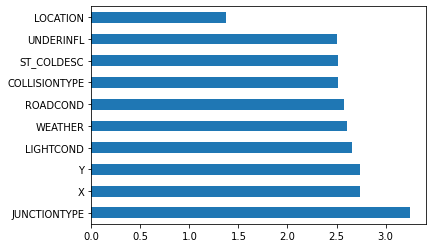

In [11]:
print('Percentage of NULLs in columns:\n')
nulls = df.isnull().sum() * 100 / len(df)
nulls = nulls.sort_values(ascending=False)
print(nulls.head(10))

nulls.head(10).plot(kind='barh')

In [12]:
cols = ['JUNCTIONTYPE', 'WEATHER', 'LIGHTCOND', 'ROADCOND', 'COLLISIONTYPE', 'ST_COLDESC', 'LOCATION', 'ADDRTYPE']         

for i in cols:
    df[i] = df[i].fillna('Unknown')
    
df = df.fillna(-1)

In [13]:
mapper = {'Y': 1, 'N': 0}
df['UNDERINFL'] = df['UNDERINFL'].replace(mapper).astype('int64')

df['ST_COLCODE'] = pd.to_numeric(df['ST_COLCODE'], errors='coerce')
df = df.fillna(-1)

**Handling datetime columns**

In [14]:
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])
df.drop(columns=['INCDATE'], inplace=True)

In [15]:
df['INCDTTM_Day'] = df['INCDTTM'].dt.day
df['INCDTTM_Week'] = df['INCDTTM'].dt.week
df['INCDTTM_Month'] = df['INCDTTM'].dt.month
df['INCDTTM_Year'] = df['INCDTTM'].dt.year
df['INCDTTM_Hour'] = df['INCDTTM'].dt.hour
df['INCDTTM_Minute'] = df['INCDTTM'].dt.minute
df['INCDTTM_DayOfWeek'] = df['INCDTTM'].dt.dayofweek

df.drop(columns=['INCDTTM'], inplace=True)

**Encoding non-numeric columns**

In [16]:
df['ST_COLCODE'] = pd.to_numeric(df['ST_COLCODE'], errors='coerce')

obj_cols = df.select_dtypes('object').columns.tolist()

le = LabelEncoder()
for i in obj_cols:    
    df[i] = le.fit_transform(df[i])

### 2. Exploratory Data Analyis  <a name="eda"></a>

**Target count plot**

0    136485
1     58188
Name: SEVERITYCODE, dtype: int64


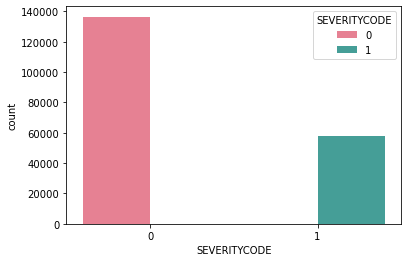

In [17]:
sns.countplot(x=y, hue=y,data=y, palette='husl')
print(y.value_counts())

**Correlation heatmap**

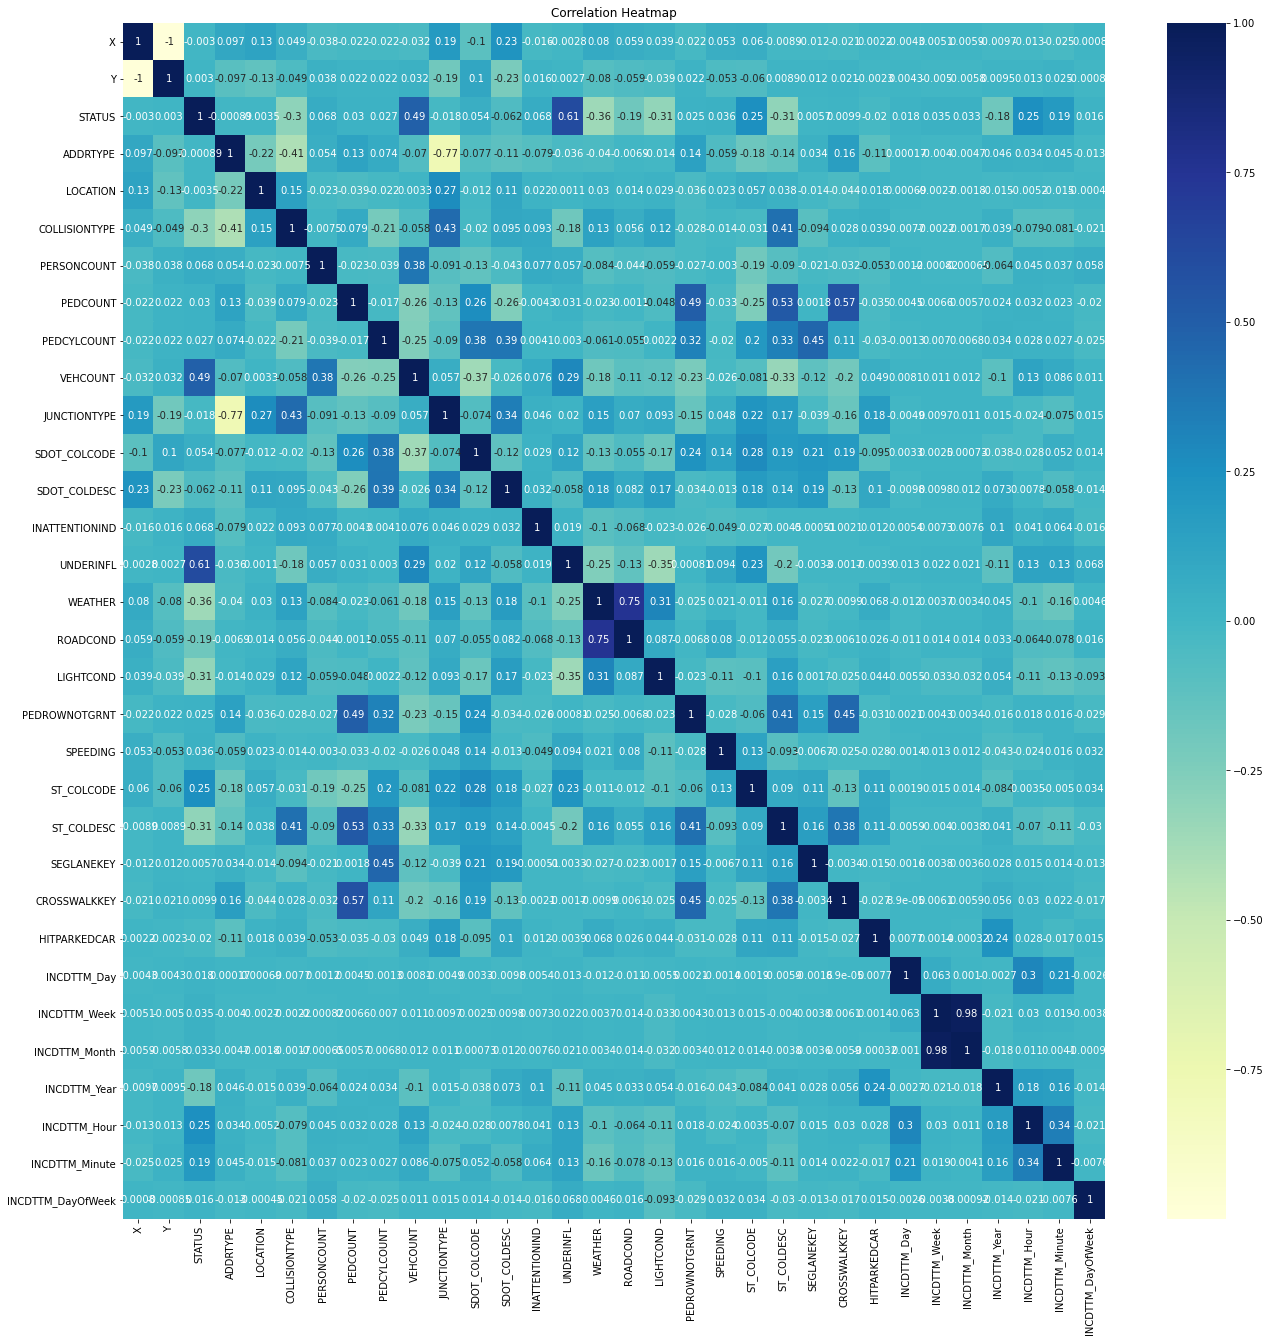

In [18]:
corr = df.corr()
plt.figure(figsize = (22,22))
plt.title('Correlation Heatmap')
sns.heatmap(corr, annot=True, cmap='YlGnBu')

### 3. Modelling  <a name="modelling"></a>

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=42)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_sample(X_train, y_train)

results = pd.DataFrame(columns=['Classifier', 'Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score'])
res_list = []

In [47]:
def get_metrics(y_test, y_pred):
    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    pr = round(precision_score(y_test, y_pred), 2)
    rc = round(recall_score(y_test, y_pred), 2)
    f1 = round(f1_score(y_test, y_pred), 2)
    print('Accuracy Score: ', acc)
    print('Precision Score: ', pr)
    print('Recall Score: ', rc)
    print('F1 Score: ', f1)
    
    cf = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf, annot=True, fmt='', cmap='Blues', 
            xticklabels=['Severity: 1', 'Severity: 2'],
            yticklabels=['Severity: 1', 'Severity: 2'])
    plt.ylabel('Predicted Class')
    plt.xlabel('Actual Class')
    
    return pr, rc, f1, acc


def feature_imp(model, name):
    top5 = pd.DataFrame(model.feature_importances_, index=df.columns)
    top5.columns = ['Feature Importance']
    top5 = top5.sort_values(by='Feature Importance',ascending=False)
    print(name + ' Top 5 Features: ')
    print(top5.head(5))
    print()

**Decision Tree Classfier**

Accuracy Score:  67.87
Precision Score:  0.46
Recall Score:  0.52
F1 Score:  0.49


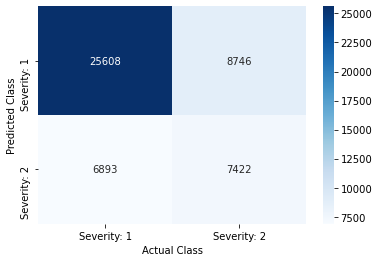

In [48]:
dt = DecisionTreeClassifier(random_state=0)
model = dt.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

pr, rc, f1, acc = get_metrics(y_test, y_pred)
res_list.append(['Decision Tree Classifier', pr, rc, f1, acc])

In [49]:
feature_imp(dt, 'Decision Tree')

Decision Tree Top 5 Features: 
              Feature Importance
ST_COLCODE              0.145719
JUNCTIONTYPE            0.095947
LOCATION                0.073180
Y                       0.070355
X                       0.069382



**Random Forest Classifier**

Accuracy Score:  74.08
Precision Score:  0.57
Recall Score:  0.5
F1 Score:  0.53


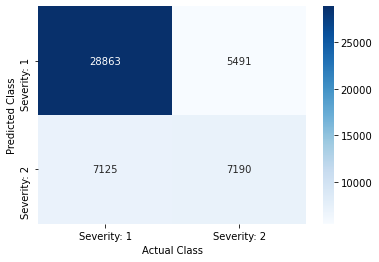

In [22]:
rf = RandomForestClassifier()
model = rf.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

pr, rc, f1, acc = get_metrics(y_test, y_pred)
res_list.append(['Random Forest Classifier', pr, rc, f1, acc])

In [50]:
feature_imp(rf, 'Random Forest')

Random Forest Top 5 Features: 
               Feature Importance
ST_COLCODE               0.082229
ST_COLDESC               0.074933
Y                        0.065029
LOCATION                 0.064311
COLLISIONTYPE            0.063967



**XGBoost Classifier**

Accuracy Score:  74.63
Precision Score:  0.58
Recall Score:  0.53
F1 Score:  0.55


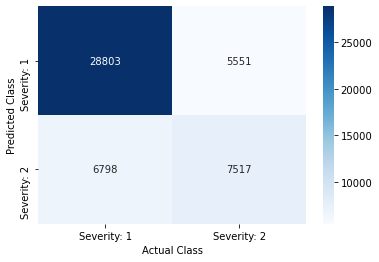

In [23]:
xgb = XGBClassifier()
model = xgb.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

pr, rc, f1, acc = get_metrics(y_test, y_pred)
res_list.append(['XGBoost Classifier', pr, rc, f1, acc])

In [51]:
feature_imp(xgb, 'XGBoost')

XGBoost Top 5 Features: 
               Feature Importance
JUNCTIONTYPE             0.184995
ST_COLDESC               0.112838
COLLISIONTYPE            0.103093
ST_COLCODE               0.078874
ROADCOND                 0.075546



**K Nearest Neighbours**

In [24]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_resampled)
X_test_scaled = sc.transform(X_test)

Accuracy Score:  67.38
Precision Score:  0.46
Recall Score:  0.6
F1 Score:  0.52


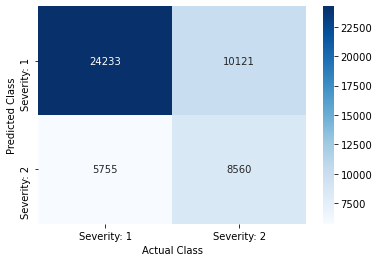

In [25]:
knn = KNeighborsClassifier()
model = knn.fit(X_train_scaled, y_resampled) 
y_pred = model.predict(X_test_scaled)

pr, rc, f1, acc = get_metrics(y_test, y_pred)
res_list.append(['k-Nearest Neighbour', pr, rc, f1, acc])

**Support Vector Machines**

Accuracy Score:  71.17
Precision Score:  0.51
Recall Score:  0.61
F1 Score:  0.56


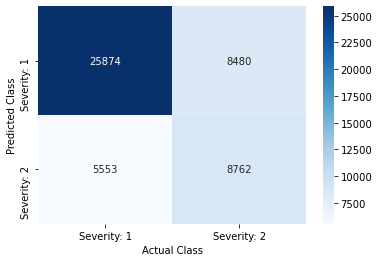

In [26]:
svm = svm.SVC(C = 1.0)
model = svm.fit(X_train_scaled ,y_resampled)
y_pred = model.predict(X_test_scaled)

pr, rc, f1, acc = get_metrics(y_test, y_pred)
res_list.append(['Support Vector Machines', pr, rc, f1, acc])

**Logistic Regression**

Accuracy Score:  67.91
Precision Score:  0.46
Recall Score:  0.57
F1 Score:  0.51


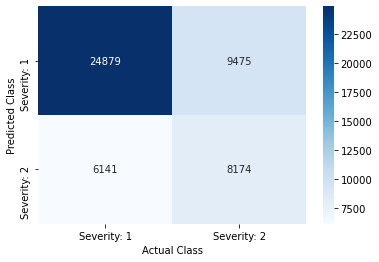

In [27]:
lr = LogisticRegression()
model = lr.fit(X_train_scaled ,y_resampled)
y_pred = model.predict(X_test_scaled)

pr, rc, f1, acc = get_metrics(y_test, y_pred)
res_list.append(['Logistic Regression', pr, rc, f1, acc])

### 4. Evaluation <a name="results"></a>

In [28]:
results = pd.DataFrame()
results = results.append(res_list, ignore_index=False)

results.columns = ['Classifier', 'Precision', 'Recall', 'F1 Score', 'Accuracy']
results

,Classifier,Precision,Recall,F1 Score,Accuracy
0,Decision Tree Classifier,0.46,0.52,0.49,67.87
1,Random Forest Classifier,0.57,0.50,0.53,74.08
2,XGBoost Classifier,0.58,0.53,0.55,74.63
3,k-Nearest Neighbour,0.46,0.60,0.52,67.38
4,Support Vector Machines,0.51,0.61,0.56,71.17
5,Logistic Regression,0.46,0.57,0.51,67.91


#### Our best model was XGBoost classifier with an accuracy of 74.63% and F1 Score of 0.55